# Data mining project 22/23

## Import libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # to avoid possible memory leak with KMeans

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# kmeans, bisecting kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, AgglomerativeClustering
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import *
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors

## Theory

To understand first each variable, let's review some audio concepts:

The Ryerson Audio-Visual database of Emotional Speech and Song has the following variables: 
A **sample** of an audio is a portion of an audio's wave in certain (small) interval.

The **sample rate** is the number of samples taken per second. This is a frequency and it is measured in kilohertz (kHz). Remember that the more often you take samples of the original audio, the closer to the original you can get.

For understanding the difference between sample and frame take into consideration these formulas:

* Sample rate = number of samples / second
* Frame = 1 sample from each channel (PCM)
* Frame Size = Sample size * Channels
* Frame Rate = frames / second

For PCM, which is a digital representation of an analog signal, the sample rate and the frame rate are the same since a frame consists of a a sample from each channel.

The sample size is the size of an individual sample, also called **Bit Depth** or **Sample Width**, and it indicates how many byte of information a sample contains. (This is one important factor in the quality/resolution of the audio).

An **audio channel** is the path via a signal or data is delivered, i.e, it's where a sound signal is conveyed from the player source to the speaker. For one channel we talk about **mono**, and several channels we refer to **stereo**.  For instance, in stereo sound, there are two audio sources: one speaker on the left, and one on the right. Each of these is represented by one channel.

An **audio frame** is a data record that contains the samples of all the channels available in an audio signal to the same point in time.

The **zero-crossing rate** is the rate at which a signal changes from positive to zero or negative, and from negative to zero or positive. It's a measure of the smoothness of the signal. The zero-crossing rate can be utilized as a basic pitch detection algorithm for monophonic tonal signals and is a key feature to classify percussive sounds.

**Mel-Frequency Cepstral Coefficients** is a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope.

**Spectral Centroid** indicates where the center of mass of the spectrum is located, and it is a good predictor of the 'brightness' of a sound, which depends on distribution of total power between high and low frequencies. Also can be seen as the amplitude-weighted mean of several frequency components.

**stft chromagram**: applying the Fourier transform, which is used to convert a time-dependent signal to a frequency-dependent signal, to local sections of an audio signal, one obtains the short-time Fourier transform (STFT). The Chroma feature or chromagram of an audio represents the intensity of the twelve distinctive pitch classes that are used to study music.

* 'Modality': media file types (audio-only).
* 'Actor' and 'Sex': corresponding identifier of the actor (01 to 24) and its sex (M of F).
* 'statement': phrase repeated by the actors ("Kids are talking by the door", "Dogs are sitting by the door").
* 'repetition': number of repetitions (1st repetition, 2nd repetition).
* 'vocal chanel': type of channel (speech or song).
* 'Emotion': the emotion of the speaker (neutral, calm, happy, sad, angry, fearful, disgust, surprised).
* 'Emotional intensity': level of emotion of each expression (normal, strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* sample_width: number of bytes of storage needed to save the sample (1 means 8-bit, 2 means 16-bit).
* frame_rate: frequency of samples used (in Hertz).
* frame_width: Number of bytes for each frame. One frame contains a sample for each channel.
* length_ms: audio file length in milliseconds.
* frame_count: number of frames from the sample.
* intensity: loudness in dBFS, which is dB relative to the maximum possible loudness.
* zero_crossings_sum: sum of the zero-crossing rate.
* 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the original audio signal.
* mfcc_ 'mean', 'std', 'min', 'max': statistics of the Mel-Frequency Cepstral Coefficients.
* sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the spectral centroid.
* stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the stft chromagram.

Measures to understand the shape of the data:
**Skewness** (skew) measures the symmetry of the distribution

**Kurtosis** (kur) measures the heaviness of the distribution tails, i.e., provides an indication of the presence of outliers.

### Data semantics

## Classification of the variables
* **Nominal/Categorical:** actor, sex, modality, statement, repetition, vocal channel, emotion.
* **Ordinal:**  emotional intensity.
* **Numeric:**   /
* **Ratio-Scaled:** lenght_ms, zero_crossings_sum, frame_rate, frame_width, sample_width, stft_mean, stft_std, stft_min, stft_max, stft_kur, stft_skew, sc_mean, sc_std, sc_min, sc_max, sc_kur, sc_skew, mfcc_mean, mfcc_std, mfcc_min, mfcc_max, 'std', 'min', 'max', 'kur', 'skew'.

The classification of variables depends on the real data?
**The data contained in the dataset are enough.**

What does characteristics of variables mean? It's just about the classification and the domain?
**Charateristics mean std, means, medians, if it's continous or categorical, etc.**

For emotion, is it nominal or ordinal? What about partial ordered sets?
**Emotion is nominal and partial order sets we take like they are not ordered.**

## Data understanding and preparation

In [3]:
df_ini = pd.read_csv("ravdess_features.csv") # read csv file (dataset)

In [4]:
df = df_ini.copy()
df

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,...,0.000000,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,...,0.000000,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,...,0.000000,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,calm,strong,Kids are talking by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247
2448,audio-only,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633
2449,audio-only,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M,1,2,...,0.000000,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821
2450,audio-only,speech,surprised,normal,Kids are talking by the door,1st,NaN,M,1,2,...,0.001565,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966


In [5]:
df.describe().round(2) # some descriptive statistics

,actor,channels,sample_width,frame_rate,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
count,1326.00,2452.00,2452.0,2452.0,2452.0,2452.00,2452.00,1636.00,2452.00,2452.00,...,2452.00,2452.0,2452.00,2452.00,2452.0,2452.00,2452.00,2452.00,2452.00,2452.00
mean,12.58,1.00,2.0,48000.0,2.0,4092.15,193587.19,-37.63,12885.31,-28.77,...,0.00,1.0,-1.25,0.11,0.0,0.02,-0.16,0.18,11.20,-0.05
std,6.92,0.05,0.0,0.0,0.1,598.32,36825.37,8.45,3665.32,4.46,...,0.00,0.0,0.21,0.33,0.0,0.02,0.18,0.20,6.61,0.45
min,1.00,1.00,2.0,48000.0,2.0,2936.00,-1.00,-63.86,4721.00,-43.81,...,0.00,1.0,-1.67,-0.99,-0.0,0.00,-1.00,0.00,1.76,-2.36
25%,7.00,1.00,2.0,48000.0,2.0,3604.00,172972.00,-43.54,10362.50,-31.83,...,0.00,1.0,-1.39,-0.09,-0.0,0.01,-0.20,0.06,6.52,-0.34
50%,13.00,1.00,2.0,48000.0,2.0,4004.00,190591.00,-37.07,12383.50,-28.68,...,0.00,1.0,-1.29,0.13,-0.0,0.01,-0.10,0.11,9.83,0.00
75%,19.00,1.00,2.0,48000.0,2.0,4538.00,217817.00,-31.59,14966.00,-25.55,...,0.00,1.0,-1.15,0.34,0.0,0.03,-0.05,0.22,14.09,0.26
max,24.00,2.00,2.0,48000.0,4.0,6373.00,305906.00,-16.35,30153.00,-15.49,...,0.04,1.0,0.79,1.47,0.0,0.15,-0.01,1.00,59.09,1.80


In [6]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
modality,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,...,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only
vocal_channel,speech,speech,NaN,NaN,song,speech,speech,speech,speech,song,...,song,speech,speech,speech,NaN,speech,speech,song,speech,NaN
emotion,fearful,angry,happy,surprised,happy,fearful,angry,neutral,calm,sad,...,sad,calm,neutral,surprised,sad,calm,calm,sad,surprised,neutral
emotional_intensity,normal,normal,strong,normal,strong,normal,normal,normal,normal,strong,...,strong,normal,normal,strong,normal,strong,normal,strong,normal,normal
statement,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,...,Kids are talking by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door
repetition,2nd,1st,2nd,1st,2nd,2nd,1st,2nd,1st,2nd,...,2nd,1st,2nd,1st,2nd,1st,1st,2nd,1st,2nd
actor,2.0,16.0,16.0,14.0,2.0,NaN,2.0,NaN,12.0,12.0,...,NaN,NaN,NaN,NaN,23.0,23.0,23.0,23.0,NaN,23.0
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
channels,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [7]:
df["stft_mean"].describe()

count    2452.000000
mean        0.475846
std         0.082551
min         0.214089
25%         0.415260
50%         0.475740
75%         0.530571
max         0.724077
Name: stft_mean, dtype: float64

In [8]:
nunique = df.nunique()
nunique

modality                  1
vocal_channel             2
emotion                   8
emotional_intensity       2
statement                 2
repetition                2
actor                    24
sex                       2
channels                  2
sample_width              1
frame_rate                1
frame_width               2
length_ms                95
frame_count             158
intensity               989
zero_crossings_sum     2176
mfcc_mean              2451
mfcc_std               2449
mfcc_min               2451
mfcc_max               2449
sc_mean                2451
sc_std                 2451
sc_min                 1431
sc_max                 2423
sc_kur                 2451
sc_skew                2451
stft_mean              2451
stft_std               2451
stft_min               1431
stft_max                  1
stft_kur               2451
stft_skew              2451
mean                   2450
std                    2451
min                    2148
max                 

In [9]:
to_delete = []
for key, value in nunique.items():
    if(value == 1):
        print("To delete: ", key)
        to_delete.append(key)
    if(value > 1 and value < 100):
        print("To evaluate: ", key)

To delete:  modality
To evaluate:  vocal_channel
To evaluate:  emotion
To evaluate:  emotional_intensity
To evaluate:  statement
To evaluate:  repetition
To evaluate:  actor
To evaluate:  sex
To evaluate:  channels
To delete:  sample_width
To delete:  frame_rate
To evaluate:  frame_width
To evaluate:  length_ms
To delete:  stft_max


In [10]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
modality,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,...,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only
vocal_channel,speech,speech,NaN,NaN,song,speech,speech,speech,speech,song,...,song,speech,speech,speech,NaN,speech,speech,song,speech,NaN
emotion,fearful,angry,happy,surprised,happy,fearful,angry,neutral,calm,sad,...,sad,calm,neutral,surprised,sad,calm,calm,sad,surprised,neutral
emotional_intensity,normal,normal,strong,normal,strong,normal,normal,normal,normal,strong,...,strong,normal,normal,strong,normal,strong,normal,strong,normal,normal
statement,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,...,Kids are talking by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door
repetition,2nd,1st,2nd,1st,2nd,2nd,1st,2nd,1st,2nd,...,2nd,1st,2nd,1st,2nd,1st,1st,2nd,1st,2nd
actor,2.0,16.0,16.0,14.0,2.0,NaN,2.0,NaN,12.0,12.0,...,NaN,NaN,NaN,NaN,23.0,23.0,23.0,23.0,NaN,23.0
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
channels,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [11]:
df = df.drop(columns=to_delete)

In [12]:
df = df.drop(columns=["mean"])

In [13]:
def get_emotion_positivity(x):
    if(x == 'fearful' or x == 'angry' or x =='sad' or x == 'disgust'):
        return -1;
    if(x == 'happy' or x == 'surprised'): # is calm positive?
        return 1;
    return 0;

df["emotion_positivity"] = df["emotion"].map(get_emotion_positivity)
df["emotion_positivity"]

0      -1
1      -1
2       1
3       1
4       1
       ..
2447    0
2448    0
2449   -1
2450    1
2451    0
Name: emotion_positivity, Length: 2452, dtype: int64

In [14]:
df["length"] = df["length_ms"] / 1000
df = df.drop(columns=["length_ms"])

In [15]:
df["zero_crossings_rate"] = df["zero_crossings_sum"] / df["length"]
df["zero_crossings_rate"]

0       4547.765587
1       3561.987705
2       4008.349390
3       3194.116030
4       3437.102634
           ...     
2447    2143.539631
2448    2148.885159
2449    1863.905325
2450    2599.946481
2451    2456.867344
Name: zero_crossings_rate, Length: 2452, dtype: float64

In [16]:
df = df.drop(columns=["zero_crossings_sum"])

In [17]:
df['statement'] = df['statement'].replace(['Dogs are sitting by the door'], '0')
df['statement'] = df['statement'].replace(['Kids are talking by the door'], '1')

### Checking synctactic accuracy

In [18]:
df_ini["modality"].value_counts()

audio-only    2452
Name: modality, dtype: int64

In [19]:
df_ini["vocal_channel"].value_counts()

speech    1335
song       921
Name: vocal_channel, dtype: int64

In [20]:
df_ini["emotion"].value_counts()

fearful      376
angry        376
happy        376
calm         376
sad          376
surprised    192
disgust      192
neutral      188
Name: emotion, dtype: int64

In [21]:
df_ini["emotional_intensity"].value_counts()

normal    1320
strong    1132
Name: emotional_intensity, dtype: int64

In [22]:
df_ini["statement"].value_counts()

Dogs are sitting by the door    1226
Kids are talking by the door    1226
Name: statement, dtype: int64

In [23]:
df_ini["repetition"].value_counts()

2nd    1226
1st    1226
Name: repetition, dtype: int64

In [24]:
df_ini["sex"].value_counts()

M    1248
F    1204
Name: sex, dtype: int64

In [25]:
df_ini["actor"].value_counts()

22.0    65
12.0    63
14.0    62
20.0    61
8.0     61
19.0    60
13.0    60
2.0     58
16.0    58
24.0    58
5.0     58
10.0    56
21.0    55
11.0    55
6.0     55
17.0    55
4.0     52
3.0     51
1.0     51
7.0     51
23.0    51
9.0     51
15.0    44
18.0    35
Name: actor, dtype: int64

In this way we check if there are some strange values or entries that are not in the domain. At the same time, we check the mode of each variable. As result, we find that all nominal/categorical and ordinal variables values seems to be synctactically accurate.

### Checking semantic accuracy

In [26]:
actors = df[["actor", "sex"]]
actors.value_counts()

actor  sex
22.0   F      65
12.0   F      63
14.0   F      62
20.0   F      61
8.0    F      61
13.0   M      60
19.0   M      60
16.0   F      58
2.0    F      58
24.0   F      58
5.0    M      58
10.0   F      56
11.0   M      55
6.0    F      55
17.0   M      55
21.0   M      55
4.0    F      52
9.0    M      51
7.0    M      51
3.0    M      51
23.0   M      51
1.0    M      51
15.0   M      44
18.0   F      35
dtype: int64

In [27]:
emo_EI = df[["emotion", "emotional_intensity"]]
emo_EI.value_counts()

emotion    emotional_intensity
angry      normal                 188
           strong                 188
calm       normal                 188
           strong                 188
fearful    normal                 188
           strong                 188
happy      normal                 188
           strong                 188
neutral    normal                 188
sad        normal                 188
           strong                 188
disgust    normal                  96
           strong                  96
surprised  normal                  96
           strong                  96
dtype: int64

We check if there are some semantic inconsistencies in the couples actor-sex (for instance duplicate actors with different sex) and emotion-emotional_intensity (there must be no _strong_ emotional_intensity values with _neutral_ emotion values). There seems to be no semantic inconsistencies.

### NaN values

In [28]:
df.isna().sum()

vocal_channel           196
emotion                   0
emotional_intensity       0
statement                 0
repetition                0
actor                  1126
sex                       0
channels                  0
frame_width               0
frame_count               0
intensity               816
mfcc_mean                 0
mfcc_std                  0
mfcc_min                  0
mfcc_max                  0
sc_mean                   0
sc_std                    0
sc_min                    0
sc_max                    0
sc_kur                    0
sc_skew                   0
stft_mean                 0
stft_std                  0
stft_min                  0
stft_kur                  0
stft_skew                 0
std                       0
min                       0
max                       0
kur                       0
skew                      0
emotion_positivity        0
length                    0
zero_crossings_rate       0
dtype: int64

In this way we check if there are NaN values (missing values) and how many they are. We decide to replace all possible values in _vocal_channel_ attribute and drop all missing values for _intensity_ attribute. Since we don't use (for the first part of the project) the attribute _actor_ we decide to do anything with it.

Suming the 0 values we obtain that sc_min and stft_min can be correlated because have the same quantity of 0 values = 1021.

### Charts and relations

**Charts and graphics parameters**

In [29]:
# dimensioni grafico e font
plt.rcParams["figure.figsize"] = [12, 8]
# per togliere eventuali sovrapposizioni
sns.set_context("notebook", font_scale = 1.1, rc = {"font.size": 16, "axes.titlesize": 16, "axes.labelsize": 16})

In [30]:
vocal_channel = pd.crosstab(df["sex"], df["vocal_channel"])
vocal_channel

vocal_channel,song,speech
sex,,
F,434,671
M,487,664


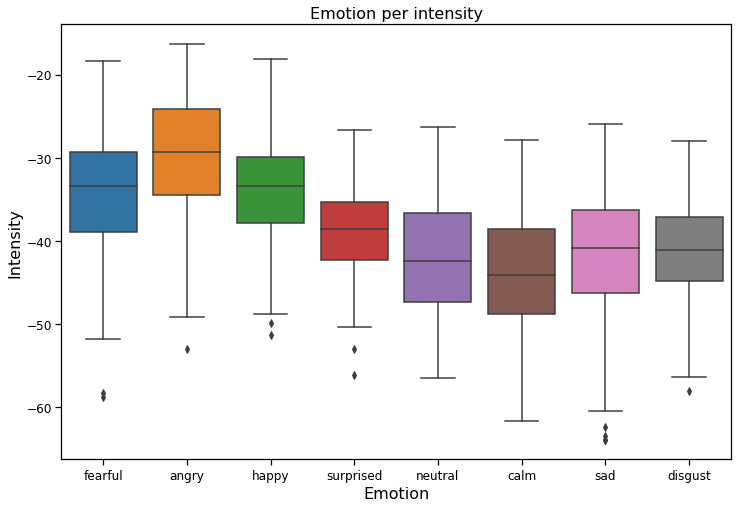

In [31]:
sns.boxplot(x = "emotion", y = "intensity", data = df)
plt.title("Emotion per intensity")
plt.xlabel("Emotion")
plt.ylabel("Intensity")
#plt.savefig("boxplot_emotionIntensity.png")
plt.show()

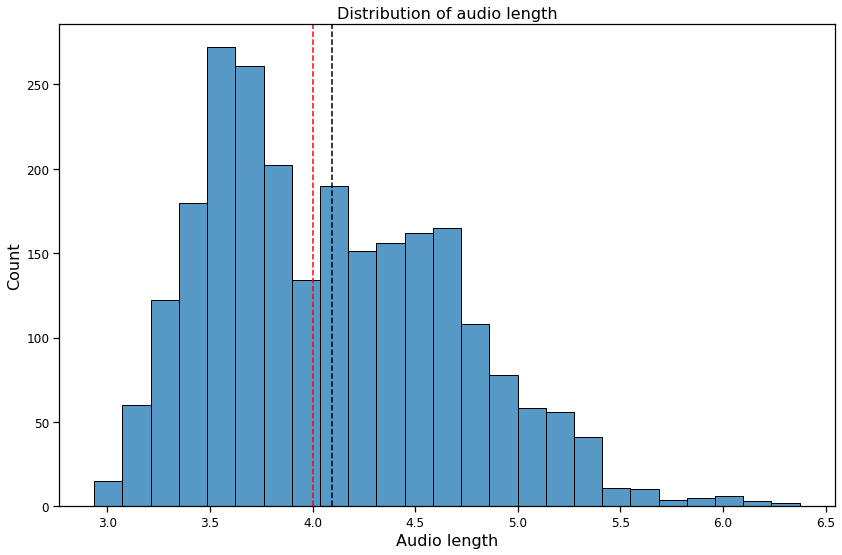

In [32]:
sns.histplot(df["length"])
plt.title("Distribution of audio length")
plt.xlabel("Audio length")
plt.ylabel("Count")
plt.axvline(df['length'].mean(), color = "k", linestyle = "--") # mean (black dotted line)
plt.axvline(df['length'].median(), color = "r", linestyle = "--") # median (red dotted line)
plt.tight_layout()
#plt.savefig("histplot_lenghtms.png")
plt.show()

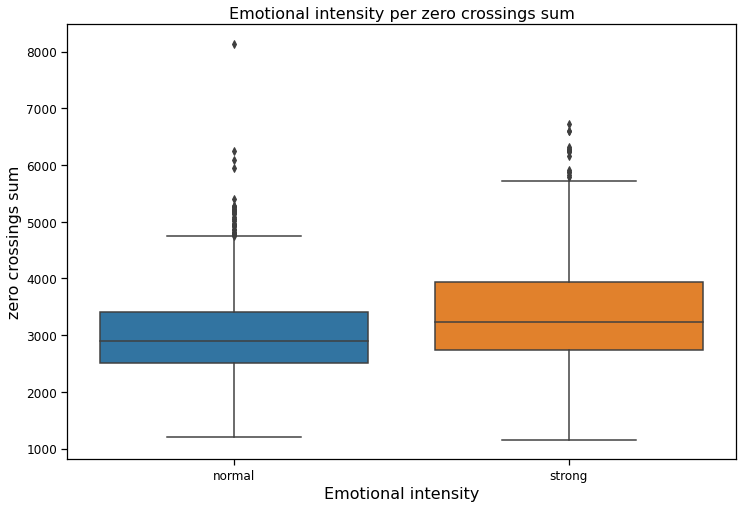

In [33]:
sns.boxplot(x = "emotional_intensity", y = "zero_crossings_rate", data = df)
plt.title("Emotional intensity per zero crossings sum")
plt.xlabel("Emotional intensity")
plt.ylabel("zero crossings sum")
#plt.savefig("boxplot_EI-ZCS.png")
plt.show()

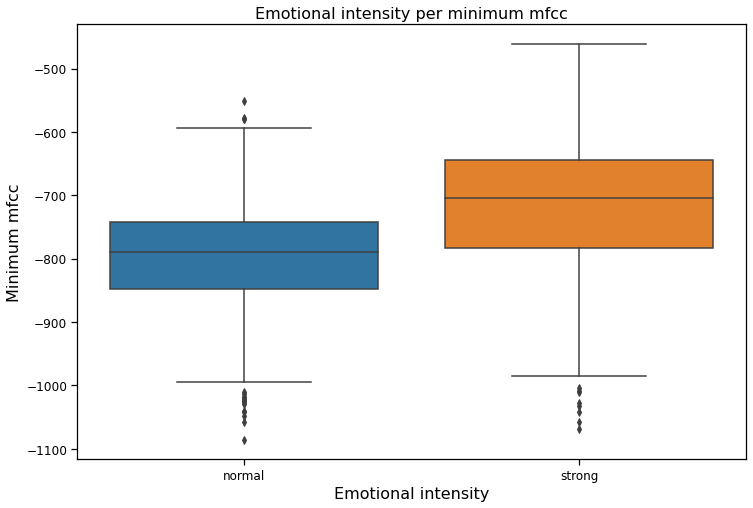

In [34]:
sns.boxplot(x = "emotional_intensity", y = "mfcc_min", data = df)
plt.title("Emotional intensity per minimum mfcc")
plt.xlabel("Emotional intensity")
plt.ylabel("Minimum mfcc")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

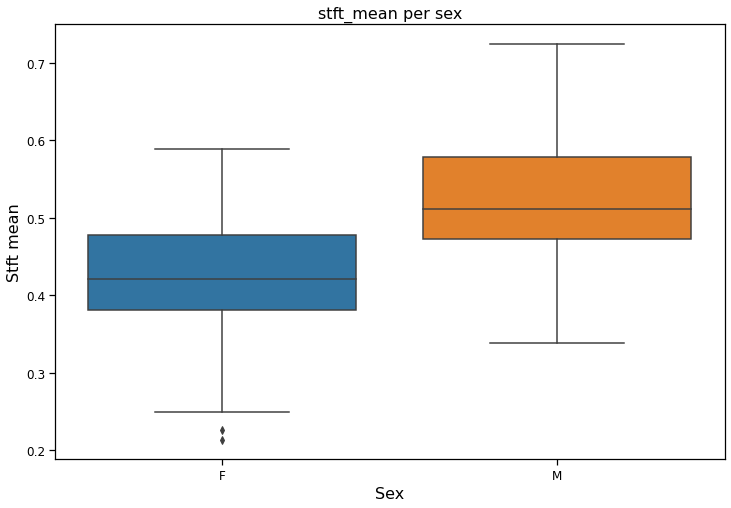

In [35]:
sns.boxplot(x = "sex", y = "stft_mean", data = df)
plt.title("stft_mean per sex")
plt.xlabel("Sex")
plt.ylabel("Stft mean")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_12464/2196359511.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


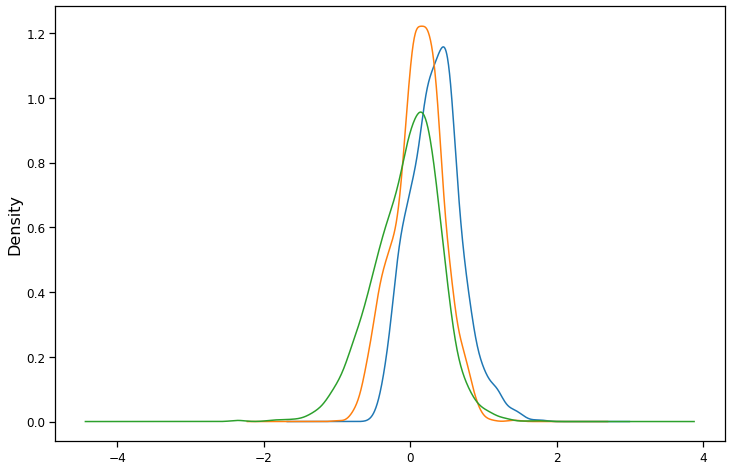

In [36]:
skew_features = df[["sc_skew","stft_skew","skew"]]
fig, ax = plt.subplots(1,1)
for s in skew_features.columns:
    df[s].plot(kind='density')
fig.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_12464/2833179634.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


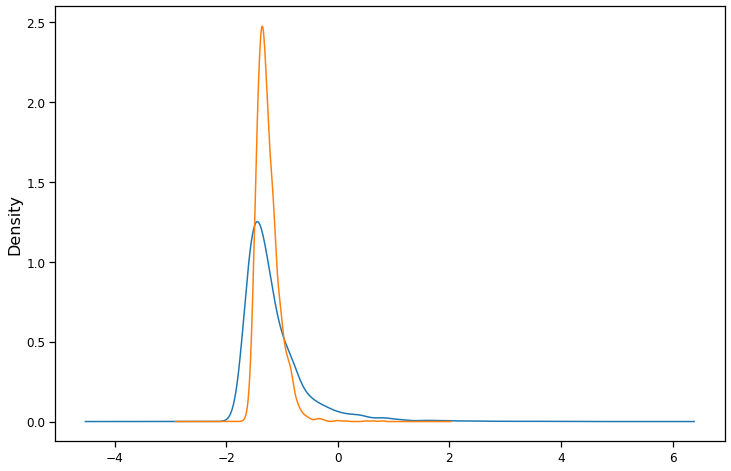

In [37]:
kur_features = df[["sc_kur","stft_kur"]]
fig, ax = plt.subplots(1,1)
for s in kur_features.columns:
    df[s].plot(kind='density')
fig.show()

## Outliers

**Outliers functions**

In [38]:
df_c = df.copy()

In [39]:
# for boxplots and stats to show
def outliers(variable) :
    Q1 = df[variable].quantile(0.25, interpolation = 'linear')
    Q3 = df[variable].quantile(0.75, interpolation = 'linear')
    IQR = Q3 - Q1
    Lowerfence = Q1 - 1.5*IQR
    Upperfence = Q3 + 1.5*IQR
    OUTLIERS = df.loc[(df[variable] < Lowerfence)  |  (df[variable] > Upperfence) ]
    NORMAL_Spec = df.loc[(df[variable] > Lowerfence)  & (df[variable] < Upperfence) ]
    return OUTLIERS[variable].round(2)

In [40]:
# for cleaning dataframe from outliers
def clean_outliers(df_o, variable, keep_outliers = False) :
    df_c = df_o.copy()
    Q1 = df_c[variable].quantile(0.25, interpolation = 'linear')
    Q3 = df_c[variable].quantile(0.75, interpolation = 'linear')
    IQR = Q3 - Q1
    Lowerfence = Q1 - 1.5*IQR
    Upperfence = Q3 + 1.5*IQR
    OUTLIERS = df_c.loc[(df_c[variable] < Lowerfence)  |  (df_c[variable] > Upperfence) ]
    NORMAL_Spec = df_c.loc[(df_c[variable] > Lowerfence)  & (df_c[variable] < Upperfence) ]
    if keep_outliers:
        return OUTLIERS
    return NORMAL_Spec

We decide to define two function for outliers computation: the first one for using it for single attributes, the other one to call it in the clustering part to make cleaner graphs.

### Outliers for single attributes

In [41]:
print(outliers("length"))

61      6.37
435     6.11
739     6.01
959     6.11
1292    6.17
1438    6.34
1617    6.07
1777    6.04
1791    5.97
1922    6.01
2158    6.04
Name: length, dtype: float64


In [42]:
print(outliers("frame_width"))

287     4
778     4
1045    4
1336    4
1348    4
1809    4
Name: frame_width, dtype: int64


In [43]:
print(outliers("stft_mean"))

748     0.72
1438    0.23
2253    0.21
Name: stft_mean, dtype: float64


In [44]:
print(outliers("stft_std"))

149     0.26
171     0.26
209     0.26
419     0.26
433     0.26
444     0.26
446     0.26
448     0.24
455     0.26
475     0.26
508     0.27
741     0.26
748     0.21
749     0.27
1007    0.27
1060    0.27
1085    0.25
1123    0.25
1125    0.27
1233    0.27
1234    0.25
1253    0.27
1291    0.24
1489    0.27
1803    0.26
1843    0.25
1849    0.27
1855    0.26
2102    0.27
2119    0.26
2120    0.26
2141    0.24
2159    0.26
Name: stft_std, dtype: float64


In [45]:
print(outliers("stft_min")) # if the output is too long to visualize look at the "Length" property

60      0.01
69      0.01
75      0.01
84      0.01
85      0.01
        ... 
2438    0.01
2439    0.02
2440    0.01
2441    0.01
2444    0.02
Name: stft_min, Length: 336, dtype: float64


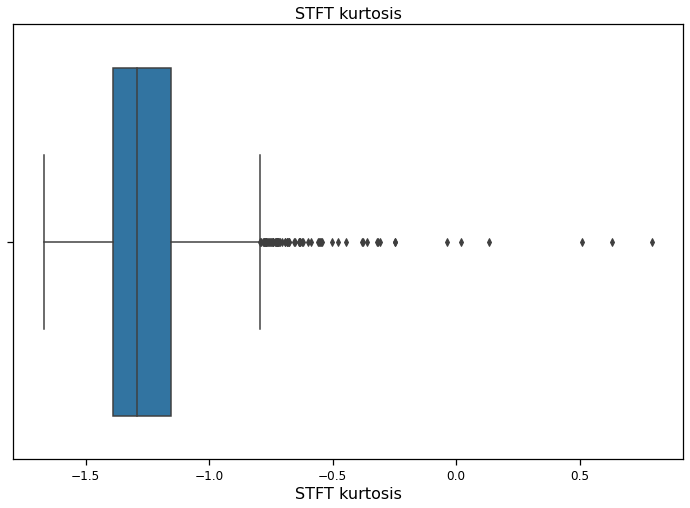

In [46]:
sns.boxplot(x = "stft_kur", data = df)
plt.title("STFT kurtosis")
plt.xlabel("STFT kurtosis")
#plt.savefig("boxplot_stftKur.png")
plt.show()

In [47]:
print(outliers("stft_kur"))

61     -0.36
119    -0.76
131    -0.64
149    -0.75
150    -0.76
        ... 
2345   -0.38
2372   -0.74
2374   -0.50
2424   -0.72
2438   -0.73
Name: stft_kur, Length: 69, dtype: float64


In [48]:
print(outliers("stft_skew"))

61      1.05
131    -0.80
171    -0.74
1028   -0.76
1085   -0.76
1425    1.00
1438    1.38
1818   -0.76
1829   -0.81
2024    1.12
2068   -0.77
2141   -0.76
2159   -0.99
2253    1.47
Name: stft_skew, dtype: float64


In [49]:
print(outliers("sc_mean"))

1545    2684.60
1687    7655.34
1791    2360.88
2253    2454.04
2277    2604.36
Name: sc_mean, dtype: float64


In [50]:
print(outliers("sc_std"))

76      1885.50
113     1696.86
129     1832.49
154     1544.54
381     1852.68
439     1852.94
497     1684.75
521     1633.91
524     1568.52
525     1491.34
591     1649.18
680     1681.33
734     1881.94
803     1855.52
827     1795.03
834     1670.17
1077    1881.54
1187    1580.81
1425    1506.39
1480    1496.55
1545    1820.60
1799    1791.24
1851    1599.72
1868    1796.64
1897    1884.65
1992    1587.00
2137    1858.15
2395    1900.73
2396    1624.71
2403    1732.09
Name: sc_std, dtype: float64


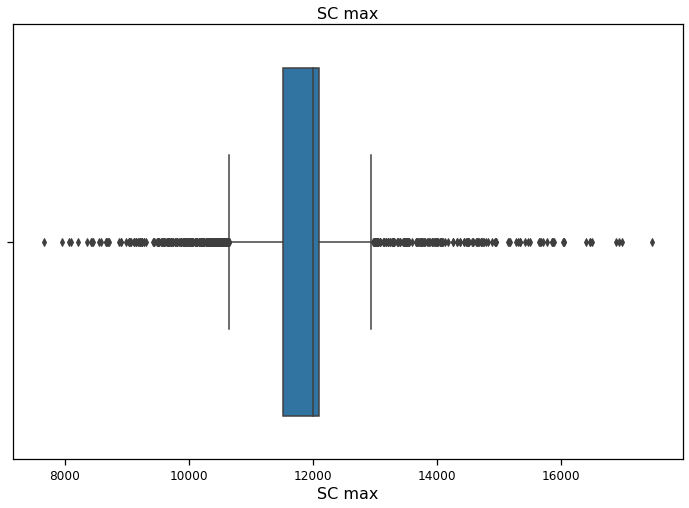

In [51]:
sns.boxplot(x = "sc_max", data = df)
plt.title("SC max")
plt.xlabel("SC max")
#plt.savefig("boxplot_scMax.png")
plt.show()

In [52]:
print(outliers("sc_max"))

0       13541.96
29      13315.14
35       9816.39
38      10321.26
40      13131.70
          ...   
2405     8698.88
2406     9443.33
2421     8907.59
2423    10439.88
2441    10365.49
Name: sc_max, Length: 439, dtype: float64


In [53]:
print(outliers("sc_kur"))

36      0.41
37      0.45
42      0.36
58     -0.17
59      1.69
        ... 
2404    1.90
2420   -0.13
2436    0.81
2437    0.85
2442   -0.08
Name: sc_kur, Length: 152, dtype: float64


In [54]:
print(outliers("sc_skew"))

37      1.30
42      1.25
59      1.36
61      1.35
83      1.42
129     1.45
435     1.39
486     1.37
733     1.26
734     1.55
784     1.31
804     1.46
809     1.40
834     1.47
952     1.47
954     1.28
971     1.75
1004    1.27
1462    1.27
1480    1.67
1527    1.35
1580    1.39
1595    1.44
1777    1.43
1791    1.55
1868    1.54
1891    1.35
1928    1.46
2024    1.25
2106    1.28
2158    1.29
2253    1.83
2399    1.27
2403    1.29
2404    1.54
Name: sc_skew, dtype: float64


In [55]:
print(outliers("mfcc_mean"))

525    -16.09
651    -41.30
823    -15.55
1380   -43.81
1392   -42.12
1479   -15.99
1480   -15.49
1563   -15.64
2025   -41.93
2300   -41.54
2319   -41.58
2404   -15.58
Name: mfcc_mean, dtype: float64


In [56]:
print(outliers("mfcc_std"))

1380    195.94
Name: mfcc_std, dtype: float64


In [57]:
print(outliers("mfcc_min"))

209    -1085.48
241    -1042.14
269     -461.49
270     -482.96
349    -1057.60
651    -1041.26
748    -1032.56
1123   -1040.88
1291   -1026.95
1380   -1068.12
1829   -1047.57
2025   -1057.28
2141   -1029.37
2300   -1028.60
Name: mfcc_min, dtype: float64


In [58]:
print(outliers("mfcc_max"))

1139    280.17
Name: mfcc_max, dtype: float64


In [59]:
print(outliers("std"))

17      0.08
36      0.06
37      0.06
101     0.09
113     0.07
        ... 
2403    0.06
2405    0.09
2417    0.07
2423    0.12
2429    0.07
Name: std, Length: 172, dtype: float64


In [60]:
print(outliers("min"))

17     -0.64
23     -0.52
33     -0.52
36     -0.52
37     -0.49
        ... 
2405   -0.68
2414   -0.47
2417   -0.76
2423   -0.98
2429   -0.67
Name: min, Length: 207, dtype: float64


In [61]:
print(outliers("max"))

17      0.64
23      0.49
33      0.59
36      0.54
101     1.00
        ... 
2405    0.83
2417    0.94
2423    1.00
2429    0.71
2430    0.50
Name: max, Length: 207, dtype: float64


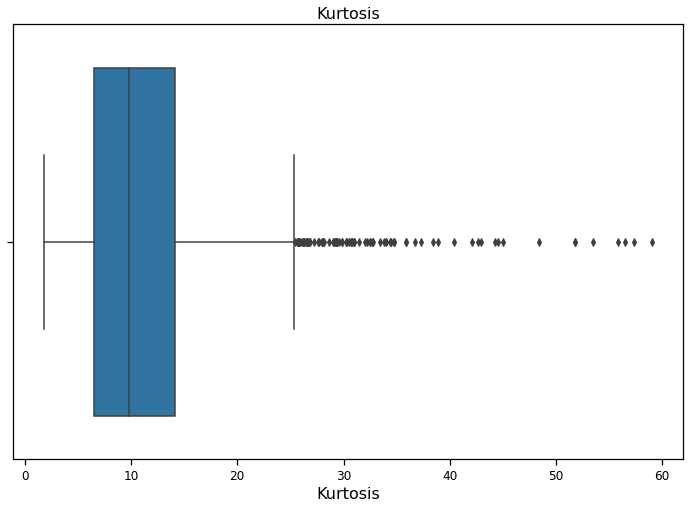

In [62]:
sns.boxplot(x = "kur", data = df)
plt.title("Kurtosis")
plt.xlabel("Kurtosis")
#plt.savefig("boxplot_kur.png")
plt.show()

In [63]:
print(outliers("kur"))

40      28.03
89      32.53
90      32.79
91      33.47
101     28.02
        ...  
2195    59.09
2289    29.90
2346    25.48
2375    29.34
2439    30.33
Name: kur, Length: 85, dtype: float64


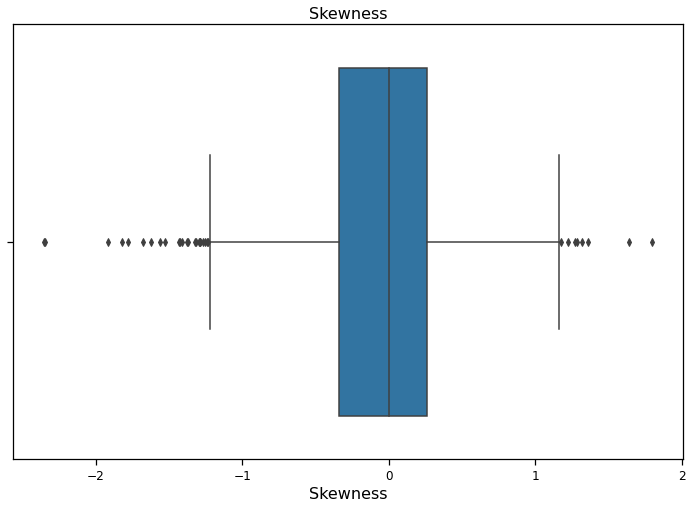

In [64]:
sns.boxplot(x = "skew", data = df)
plt.title("Skewness")
plt.xlabel("Skewness")
#plt.savefig("boxplot_skew.png")
plt.show()

In [65]:
print(outliers("skew"))

145    -1.29
153    -1.24
168    -1.42
216     1.18
433    -1.27
475     1.80
476    -1.25
508     1.22
577    -1.24
741    -1.32
758    -1.37
832    -1.32
927    -1.29
975     1.32
988     1.29
1057   -1.63
1064   -1.78
1066   -1.82
1110   -1.92
1246    1.27
1288   -1.38
1464    1.36
1522    1.64
1639   -1.29
1803   -2.35
1804   -1.53
1818   -1.41
1835   -1.56
2067   -1.43
2114   -2.36
2327   -1.29
2398   -1.68
Name: skew, dtype: float64


**Maybe at this point we can calculate outliers for categorical/nominal attributes, which are values that occurs with a frequency extremely lower than the frequency of all other values.**

# Transformation

In [66]:
df[["emotional_intensity","intensity"]]

,emotional_intensity,intensity
0,normal,-36.793432
1,normal,NaN
2,strong,-32.290737
3,normal,-49.019839
4,strong,-31.214503
...,...,...
2447,strong,NaN
2448,normal,-43.342901
2449,strong,NaN
2450,normal,-45.751265


In [67]:
df.sort_values("intensity")["intensity"].dropna()

209    -63.864613
1123   -63.864613
2025   -63.460545
2102   -62.350199
2159   -61.681723
          ...    
2345   -18.328814
1747   -18.183522
443    -17.070853
1070   -16.496218
801    -16.353953
Name: intensity, Length: 1636, dtype: float64

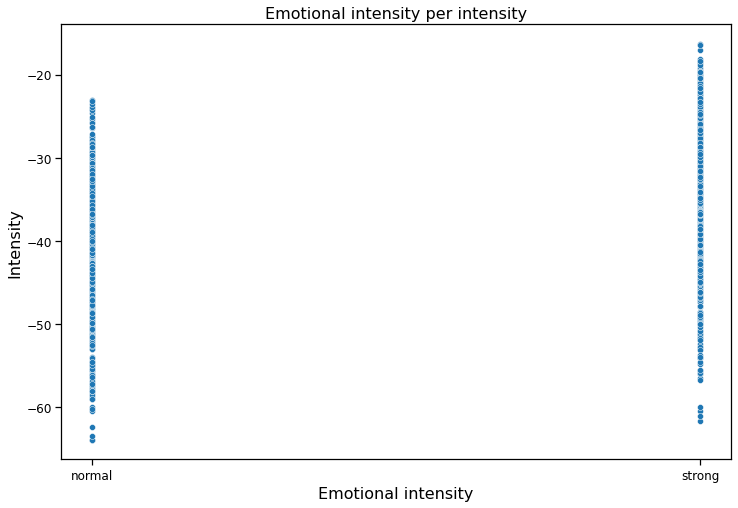

In [68]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

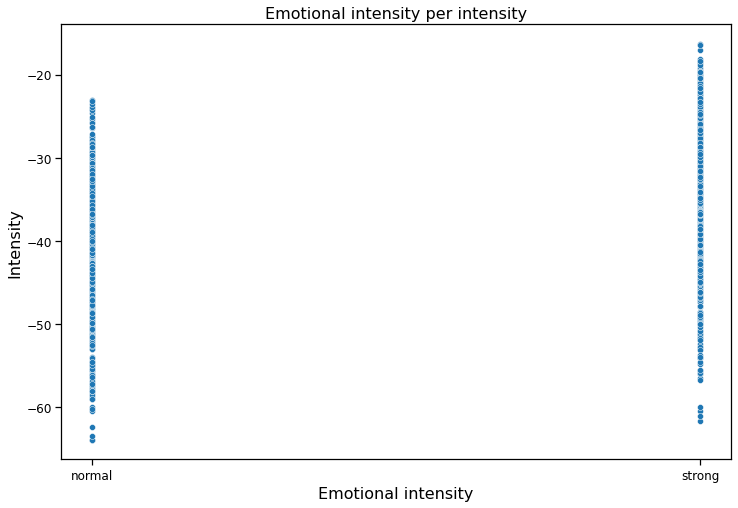

In [69]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

In [70]:
def densityPlot(vars, df_p = df):
    skew_features = df_p[vars]
    fig, ax = plt.subplots(1,1)
    for s in skew_features.columns:
        df_p[s].plot(kind = 'density')
    fig.show()

In [71]:
df_c['zero_crossings_rate_normalized'] = zscore(df_c['zero_crossings_rate'])
df_c = df_c.drop(columns=["zero_crossings_rate"])

C:\Users\claud\AppData\Local\Temp/ipykernel_12464/1849774936.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


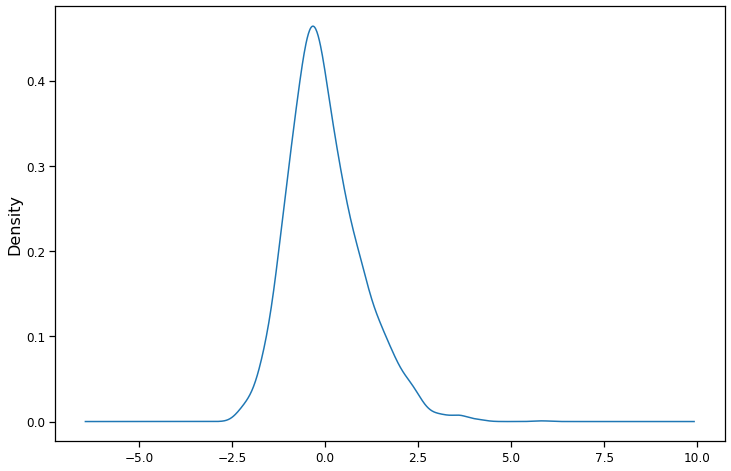

In [72]:
densityPlot(["zero_crossings_rate_normalized"], df_c)

In [73]:
df_c['sc_mean_normalized'] = zscore(df_c['sc_mean'])
df_c = df_c.drop(columns=["sc_mean"])

C:\Users\claud\AppData\Local\Temp/ipykernel_12464/1849774936.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


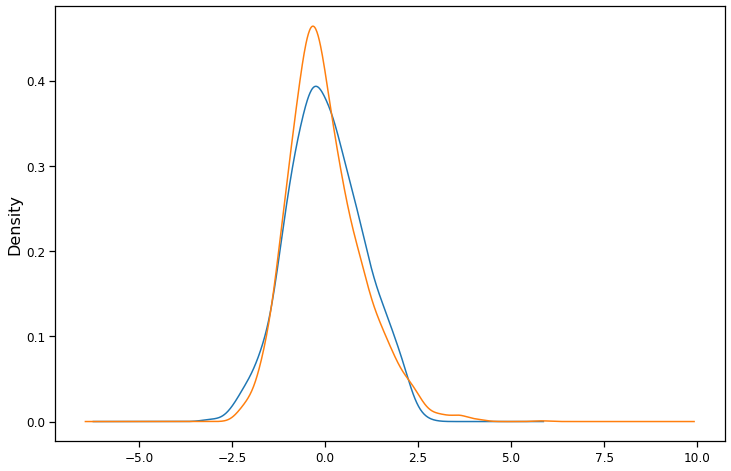

In [74]:
densityPlot(["sc_mean_normalized", "zero_crossings_rate_normalized"], df_c)

## Pairwise correlations and eventual elimination of variables

We drop _frame_rate_ column because there is just _length_ that measures the length of audio and of course _frame_rate_ is proportional to _length_.

In [75]:
df_num = df.copy() # copy of all numerical and ratio-scaled attributes

In [76]:
df_num = df_num.drop(columns = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width"])
df_num.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
frame_count,179379.000000,187387.000000,224224.000000,174575.000000,211411.000000,171371.000000,180980.000000,164965.000000,180981.000000,209810.000000,...,233834.000000,184184.000000,168168.000000,155356.000000,240240.000000,221021.000000,200200.000000,251451.000000,179379.000000,184184.000000
intensity,-36.793432,NaN,-32.290737,-49.019839,-31.214503,-36.312244,NaN,-49.095042,-45.906837,NaN,...,-29.512788,-47.141749,NaN,NaN,-36.811776,NaN,-43.342901,NaN,-45.751265,-40.018044
mfcc_mean,-33.485947,-29.502108,-30.532463,-36.059555,-31.405996,-30.500889,-30.177172,-36.048576,-33.899364,-29.462296,...,-22.787794,-28.682810,-25.771196,-25.815453,-24.805220,-30.225578,-31.160332,-26.135280,-28.242815,-29.019236
mfcc_std,134.654860,130.485630,126.577110,159.725160,122.125824,132.581730,139.507460,167.652130,159.197620,116.833786,...,113.349300,154.492430,157.241900,147.116780,138.314590,158.845500,157.499700,138.133210,159.943400,149.188950
mfcc_min,-755.223450,-713.985600,-726.060360,-842.946350,-700.702760,-719.165470,-767.193600,-910.497440,-879.260000,-645.926200,...,-659.389100,-859.211730,-821.105700,-798.653700,-782.337340,-855.924200,-825.374100,-768.365360,-868.095760,-799.510100
mfcc_max,171.690920,205.007700,165.456530,190.036090,161.134000,213.681920,228.327150,220.383730,207.632170,167.967530,...,202.859280,197.396960,251.228530,214.569700,219.623290,208.184970,220.794900,235.539380,219.843500,219.527800
sc_mean,5792.550744,5197.620555,4830.743037,5376.446478,5146.012474,4251.116912,5718.247598,6085.206268,6349.352394,5486.705835,...,3918.703428,4659.880471,5604.753887,4645.862618,4369.123635,5886.647366,6602.742127,4654.156076,5524.736973,6082.676123
sc_std,3328.055457,4040.931570,3332.131300,4053.663073,3442.724109,3833.178183,4008.803978,3737.829447,4014.630498,3602.202957,...,3149.520778,3663.074145,3300.232336,3055.279038,3194.246906,4114.260257,4191.727090,4231.511986,3596.031841,3963.725117
sc_min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,991.364402,...,979.297084,0.000000,818.317638,511.528673,840.068705,0.000000,0.000000,0.000000,760.822547,0.000000
sc_max,13541.959028,12000.290443,12007.751173,12048.223893,12025.582707,12063.200741,12840.225341,12000.006162,12081.507260,11999.999998,...,11981.598019,12192.374121,10834.058255,10919.537644,11191.358052,12210.517144,12064.561791,12207.179884,11981.912464,12199.773419


In [77]:
#sns.pairplot(df_num)
#plt.savefig("pairplot_df_num.png")
#plt.show()

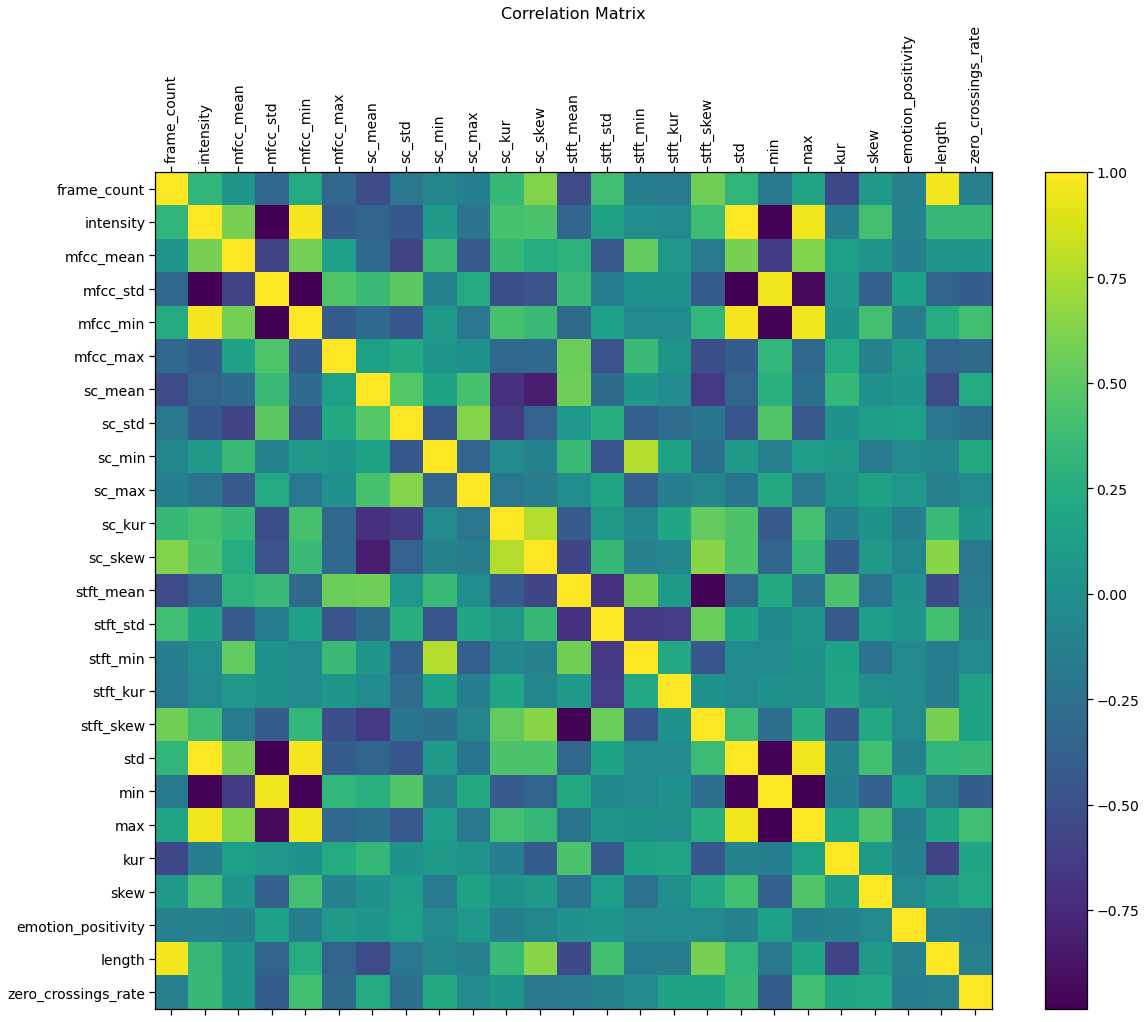

In [78]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_num.corr("spearman"), fignum=f.number)
plt.xticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [79]:
corr = df_num[["intensity", "mfcc_min", "min"]].corr("spearman")
corr.style.background_gradient(cmap='coolwarm')

,intensity,mfcc_min,min
intensity,1.000000,0.972007,-0.961140
mfcc_min,0.972007,1.000000,-0.968147
min,-0.961140,-0.968147,1.000000


In [80]:
eps = 0.90
alg = "spearman"
print("CORRELATION > ",eps,":")
corr = (df_num.corr(alg))
for index, row in corr.iterrows():
    for k, v in row.items():
        if(v > eps and index != k):
            print(index, k, corr[index][k])
    
print("")
print("CORRELATION < -",eps,":")
neg_corr = (df_num.corr(alg))
for index, row in neg_corr.iterrows():
    for k, v in row.items():
        if(v  < -eps and index != k):
            print(index, k, v)

CORRELATION >  0.9 :
frame_count length 0.9694081506422678
intensity mfcc_min 0.9720070418854267
intensity std 0.9999988455591777
intensity max 0.9552185922229272
mfcc_std min 0.9547151225687327
mfcc_min intensity 0.9720070418854267
mfcc_min std 0.9724503071103804
mfcc_min max 0.9583612373172553
std intensity 0.9999988455591777
std mfcc_min 0.9724503071103804
std max 0.9544963167048637
min mfcc_std 0.9547151225687327
max intensity 0.9552185922229272
max mfcc_min 0.9583612373172553
max std 0.9544963167048637
length frame_count 0.9694081506422678

CORRELATION < - 0.9 :
intensity mfcc_std -0.9813062948153148
intensity min -0.9611396824111241
mfcc_std intensity -0.9813062948153148
mfcc_std mfcc_min -0.9779520449582015
mfcc_std std -0.9807939916108984
mfcc_std max -0.943372431555634
mfcc_min mfcc_std -0.9779520449582015
mfcc_min min -0.9681466324554384
stft_mean stft_skew -0.9678858272596078
stft_skew stft_mean -0.9678858272596078
std mfcc_std -0.9807939916108984
std min -0.961377185614126


In [81]:
correlation_drop_cols = ["std", "mfcc_min", "max", "mfcc_std", "stft_skew", "min", "frame_count"]
df_num = df_num.drop(columns=correlation_drop_cols)

## Normalization (zscore)

In [82]:
df_norm = pd.DataFrame()
for v in df_num:
    df_norm[v] = zscore(df_num[v].dropna())
df_norm

,intensity,mfcc_mean,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,kur,skew,emotion_positivity,length,zero_crossings_rate
0,0.098457,-1.057340,-1.057499,0.711365,-0.064439,-1.086454,1.703404,0.038205,-0.276260,-0.734194,0.175121,-0.470414,0.155401,-0.271707,0.706632,-0.843294,-0.593700,1.620277
2,0.631358,-0.395268,-1.297313,-0.387835,-0.057416,-1.086454,0.176451,0.021814,0.250069,-1.164234,0.879278,-0.470414,0.023533,-0.955886,0.771504,1.589361,0.967652,0.986986
3,-1.348558,-1.634256,-0.351829,0.235821,1.185831,-1.086454,0.216732,-0.620262,-0.707327,-0.830805,1.227743,-0.470414,-0.932231,0.277804,-0.072046,1.589361,-0.760869,0.031052
4,0.758732,-0.591085,-1.463584,-0.027530,0.133143,-1.086454,0.194198,-0.043494,0.418278,-0.725426,0.811334,-0.470414,-0.561131,-0.562166,1.018217,1.589361,0.521312,0.316326
5,0.155406,-0.388191,0.557738,-1.050260,0.805921,-1.086454,0.231638,0.049107,0.585822,-1.528791,0.584186,-0.470414,0.707241,0.237831,0.168043,-0.843294,-0.872872,0.274410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,-1.126283,0.019361,-0.068684,-0.583105,0.512820,-1.086454,0.360201,0.320212,0.446676,0.211668,-0.329648,-0.470414,0.302232,0.742574,-1.038630,0.373033,-0.426532,-0.543516
2446,0.096286,0.888586,0.786280,-0.915396,-0.295000,0.567478,-0.636082,-0.585773,0.216862,-0.116744,0.401370,-0.238789,-0.843525,-0.948797,0.606874,-0.843294,1.525994,-0.439393
2448,-0.676684,-0.536015,0.831348,1.637291,1.423725,-1.086454,0.232993,-0.824295,-1.310056,1.395340,-1.053415,-0.470414,1.047797,1.710890,2.466580,0.373033,0.131810,-1.196080
2450,-0.961717,0.117993,0.794751,0.405295,0.397302,0.411457,0.150734,-0.564072,-0.402231,1.248063,-0.954492,-0.146330,-0.137849,0.401086,-0.137898,1.589361,-0.593700,-0.666520


In [83]:
df_num.describe()

,intensity,mfcc_mean,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,kur,skew,emotion_positivity,length,zero_crossings_rate
count,1636.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,-37.625332,-28.769180,199.182514,5170.101398,3365.453393,551.834124,11830.461864,-1.142642,0.348442,0.475846,0.331371,0.002272,-1.247929,11.203002,-0.048245,-0.306688,4.092151,3167.666760
std,8.451982,4.461886,26.002107,875.185444,580.479034,508.025890,1004.955976,0.572654,0.353005,0.082551,0.023773,0.004830,0.211781,6.614859,0.454925,0.822315,0.598322,851.941008
min,-63.864613,-43.812923,126.250810,2360.880942,1491.341071,0.000000,7657.495158,-1.795576,-0.510390,0.214089,0.210126,0.000000,-1.669603,1.757794,-2.356526,-1.000000,2.936000,1159.781288
25%,-43.539869,-31.828597,180.081417,4563.684781,3025.431971,0.000000,11516.034429,-1.496187,0.098549,0.415260,0.317780,0.000000,-1.390612,6.519988,-0.336624,-1.000000,3.604000,2592.111116
50%,-37.072745,-28.681109,201.697175,5122.712259,3433.835368,707.319256,12000.292653,-1.308938,0.347621,0.475740,0.334224,0.000190,-1.292105,9.828686,0.004256,-1.000000,4.004000,3040.051311
75%,-31.591309,-25.550238,218.185288,5775.959809,3768.503344,977.693852,12091.886054,-0.982944,0.557427,0.530571,0.349272,0.001999,-1.152519,14.085435,0.262978,0.000000,4.538000,3646.926511
max,-16.353953,-15.491450,280.173700,7655.335726,4819.783069,2121.417965,17477.540047,3.657953,1.825436,0.724077,0.391928,0.039378,0.794669,59.085695,1.799676,1.000000,6.373000,8130.602145


In [84]:
desc = df_num.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

intensity: 11.948559652602661
mfcc_mean: 6.278359000000002
mfcc_max: 38.10387000000003
sc_mean: 1212.2750287765466
sc_std: 743.0713734869682
sc_min: 977.6938519007109
sc_max: 575.8516251850451
sc_kur: 0.513242853914685
sc_skew: 0.45887848473075143
stft_mean: 0.115310735
stft_std: 0.03149214
stft_min: 0.0019994863500000003
stft_kur: 0.23809270305753993
kur: 7.56544712292974
skew: 0.5996017074669128
emotion_positivity: 1.0
length: 0.9340000000000002
zero_crossings_rate: 1054.8153943984444


Treshold > 15: "mfcc_max", "sc_std", "sc_min", "sc_max"

In [85]:
'''
df_num["intensity_normalized"] = zscore(df_num["intensity"].dropna())
df_num["mfcc_mean_normalized"] = zscore(df_num["mfcc_mean"])
df_num["mfcc_max_normalized"] = zscore(df_num["mfcc_max"])
df_num["sc_std_normalized"] = zscore(df_num["sc_std"])
df_num["sc_min_normalized"] = zscore(df_num["sc_min"])
df_num["sc_max_normalized"] = zscore(df_num["sc_max"])
df_num["stft_min_normalized"] = zscore(df_num["stft_min"])
df_num["mean_normalized"] = zscore(df_num["mean"])
df_num["std_normalized"] = zscore(df_num["std"])
df_num["kur_normalized"] = zscore(df_num["kur"])
df_num = df_num.drop(columns=["intensity", "mfcc_mean", "sc_std", "mfcc_max", "sc_std", "sc_min", "sc_max", "stft_min", "mean", "std", "kur"])
'''

'\ndf_num["intensity_normalized"] = zscore(df_num["intensity"].dropna())\ndf_num["mfcc_mean_normalized"] = zscore(df_num["mfcc_mean"])\ndf_num["mfcc_max_normalized"] = zscore(df_num["mfcc_max"])\ndf_num["sc_std_normalized"] = zscore(df_num["sc_std"])\ndf_num["sc_min_normalized"] = zscore(df_num["sc_min"])\ndf_num["sc_max_normalized"] = zscore(df_num["sc_max"])\ndf_num["stft_min_normalized"] = zscore(df_num["stft_min"])\ndf_num["mean_normalized"] = zscore(df_num["mean"])\ndf_num["std_normalized"] = zscore(df_num["std"])\ndf_num["kur_normalized"] = zscore(df_num["kur"])\ndf_num = df_num.drop(columns=["intensity", "mfcc_mean", "sc_std", "mfcc_max", "sc_std", "sc_min", "sc_max", "stft_min", "mean", "std", "kur"])\n'

In [86]:
desc = df_norm.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

intensity: 1.4141314054531322
mfcc_mean: 1.4228668681835692
mfcc_max: 1.4391487149696471
sc_mean: 1.3935243409795266
sc_std: 1.2692612082399437
sc_min: 1.904285780630608
sc_max: 0.6202537017814054
sc_kur: 0.9055756641986237
sc_skew: 1.2976991198493488
stft_mean: 1.365697523548826
stft_std: 1.3444438851451697
stft_min: 0.4144962846198943
stft_kur: 1.1120253248081409
kur: 1.1210107074169193
skew: 1.3248924276178258
emotion_positivity: 1.2163273032896342
length: 1.5613520068073896
zero_crossings_rate: 1.2154987831517392


In [87]:
df_norm.T

,0,2,3,4,5,7,8,13,14,15,...,2438,2439,2440,2441,2442,2443,2446,2448,2450,2451
intensity,0.098457,0.631358,-1.348558,0.758732,0.155406,-1.357459,-0.980130,-2.026256,-0.733545,0.245707,...,-1.305177,-0.728685,-0.743336,1.297006,0.960133,-1.126283,0.096286,-0.676684,-0.961717,-0.283181
mfcc_mean,-1.057340,-0.395268,-1.634256,-0.591085,-0.388191,-1.631794,-1.150014,-1.356778,-2.116519,-0.823284,...,-0.289370,0.517484,0.538685,1.758138,1.340825,0.019361,0.888586,-0.536015,0.117993,-0.056054
mfcc_max,-1.057499,-1.297313,-0.351829,-1.463584,0.557738,0.815532,0.325027,-1.740848,-1.164866,-0.833014,...,1.118028,1.330328,1.454646,0.094798,0.141431,-0.068684,0.786280,0.831348,0.794751,0.782607
sc_mean,0.711365,-0.387835,0.235821,-0.027530,-1.050260,1.045826,1.347705,0.355325,-0.966208,-0.248378,...,2.019462,0.607517,0.298355,-1.301030,-1.430158,-0.583105,-0.915396,1.637291,0.405295,1.042934
sc_std,-0.064439,-0.057416,1.185831,0.133143,0.805921,0.641629,1.118575,-0.731186,0.082613,0.261168,...,0.402658,-0.169445,-0.512277,-1.159617,-0.372066,0.512820,-0.295000,1.423725,0.397302,1.030862
sc_min,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,-1.086454,...,0.530083,0.358332,0.651561,0.160336,0.841591,-1.086454,0.567478,-1.086454,0.411457,-1.086454
sc_max,1.703404,0.176451,0.216732,0.194198,0.231638,0.168743,0.249858,0.198487,0.177374,0.274089,...,0.147046,-1.157523,-0.070086,-1.458047,0.150421,0.360201,-0.636082,0.232993,0.150734,0.367565
sc_kur,0.038205,0.021814,-0.620262,-0.043494,0.049107,-0.801472,-0.815632,1.160545,0.774579,-0.049919,...,-0.523679,-0.658453,-0.474603,0.772020,1.850079,0.320212,-0.585773,-0.824295,-0.564072,-0.626587
sc_skew,-0.276260,0.250069,-0.707327,0.418278,0.585822,-1.306701,-1.193180,1.253786,1.385199,0.580027,...,-1.839070,-1.645892,-1.134505,1.262319,2.213627,0.446676,0.216862,-1.310056,-0.402231,-0.569138
stft_mean,-0.734194,-1.164234,-0.830805,-0.725426,-1.528791,0.138848,0.717073,0.232318,-1.549968,-0.810788,...,2.204723,1.877179,1.167588,0.151425,-0.500596,0.211668,-0.116744,1.395340,1.248063,0.958383


## Partitions
vocal_channel, emotional_intensity, statement, sex, emotion_positivity

### Individuals:
1. Statement - Emotional Intensity (Claudio)
2. Emotion Positivity - Sex (Steffania)
3. Vocal Channel - Sex (Napo)

### Mix:
1. Emotional Intensity (Napo)
2. Emotional Intensity (Claudio)
3. Emotional Intensity (Steffania)


**Partition function**

In [88]:
def partition_df(df, attribute, drop_categorical = True, normalize = True):
    tmp = df.copy()
    ret = {}
    to_delete = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width", "emotion_positivity"]
    partitions = tmp[attribute].unique()
    for p in partitions:
        ret[p] = df[(tmp[attribute] == p)]
        if(drop_categorical):
            ret[p] = ret[p].drop(columns = to_delete)
            if(normalize):
                for v in ret[p]:
                    ret[p][v] = zscore(ret[p][v].dropna())
                
    return ret

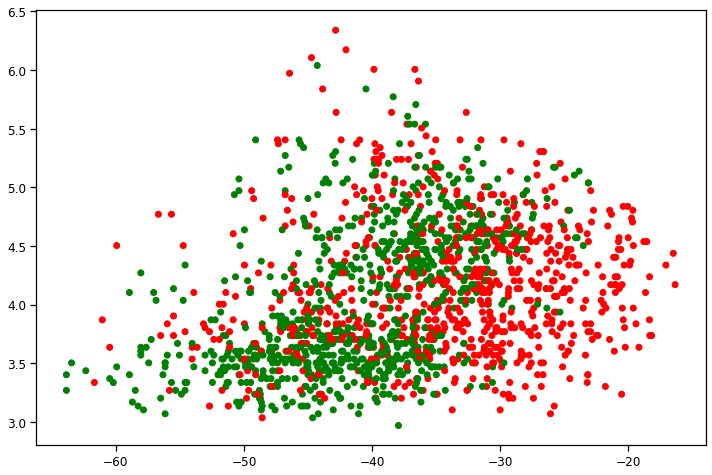

In [89]:
colors = {'strong':'red', 'normal':'green'}
plt.scatter(df['intensity'], df['length'], c=df['emotional_intensity'].map(colors))
plt.show()

We use this graph to highlight the difference between normal and strong emotional intensity. We also use this variable as the main parameter to make a comparison between our different algorithms, which help us to decide which clustering method seems the best.

## Analysis by centroid-based methods

### KMeans, Bisecting KMeans

**SSE, KMeans and Bisecting KMeans plot function**

In [90]:
def drawSSEKMeansPlots (df, column_indices, xlabel, ylabel, variables, nclusters, df_name) :
    # normalization (zscore)
    X = variables.values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scal = scaler.transform(X)
    
    # SSE plot
    sse_list = []
    for k in range(2, 18): # 15 centroids
        kmeans = KMeans(n_clusters = k, n_init = 10, max_iter = 100)
        kmeans.fit(X_scal)
        sse_list.append(kmeans.inertia_)
    sns.lineplot(x = range(2, 18), y = sse_list, marker = 'o')
    plt.title("SSE " + xlabel + ' vs ' + ylabel + " (" + df_name + ")", fontsize = 15)
    plt.xlabel('k (# of initial centroids)')
    plt.ylabel('SSE')
    plt.savefig("SSE_" + xlabel + "_" + ylabel + "_df_" + df_name + ".png")
    plt.show()
    
    # KMeans plot
    kmeans = KMeans(n_clusters = nclusters, n_init = 10, max_iter = 100)
    kmeans.fit(X_scal)
    centers = kmeans.cluster_centers_
    centers = scaler.inverse_transform(centers)
    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue = kmeans.labels_, style = kmeans.labels_, palette = "bright")
    plt.title("KMeans " + xlabel + " vs " + ylabel + " (" + df_name + ")", fontsize = 15)
    plt.legend()
    plt.scatter(centers[:, 0], centers[:, 1], c = 'black', marker = '*', s = 200)
    plt.savefig("KMeans_" + xlabel + "_" + ylabel + "_df_" + df_name + ".png")
    plt.show()
    
    # Bisecting KMeans plot
    bkmeans = BisectingKMeans(n_clusters = nclusters)
    bkmeans.fit(X_scal)
    centersbis = bkmeans.cluster_centers_
    centersbis = scaler.inverse_transform(centersbis)
    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue = bkmeans.labels_, palette = "bright", style = bkmeans.labels_)
    plt.title("Bisecting KMeans " + xlabel + " vs " + ylabel + " (" + df_name + ")", fontsize = 15)
    plt.scatter(centersbis[:, 0], centersbis[:, 1], c = 'black', marker = '*', s = 200)
    plt.savefig("Bisecting_KMeans_" + xlabel + "_" + ylabel + "_df_" + df_name + ".png")
    plt.show()

#### Partitioning and drawing plots - statement / emotional_intensity 

In [91]:
# exploration of dataset (uncomment and run only if necessary)
#def drawKMeansPlot (df, xlabel, ylabel, variables, nclusters) :
#    # normalization (zscore)
#    X = variables.values
#    scaler = StandardScaler()
#    scaler.fit(X)
#    X_scal = scaler.transform(X)
#    
#    # KMeans plot
#    kmeans = KMeans(n_clusters = nclusters, n_init = 10, max_iter = 100)
#    kmeans.fit(X_scal)
#    centers = kmeans.cluster_centers_
#    centers = scaler.inverse_transform(centers)
#    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue = kmeans.labels_, style = kmeans.labels_, palette = "bright")
#    plt.title("KMeans " + xlabel + " vs " + ylabel, fontsize = 15)
#    plt.legend()
#    plt.scatter(centers[:, 0], centers[:, 1], c = 'black', marker = '*', s = 200)
#    plt.show()
#
#tmp = df.copy()
#to_delete = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width", "emotion_positivity", "frame_count"]
#tmp = tmp.drop(columns = to_delete)
#columns_v = tmp.columns.tolist()
#nclusters = 2
#l = len(columns_v)
#for i in range(l):
#    for j in range(i+1,l):
#        xvar = columns_v[i]
#        yvar = columns_v[j]
#        tmp_cleaned = tmp[[columns_v[i],columns_v[j]]].dropna()
#        drawKMeansPlot(tmp_cleaned[[columns_v[i],columns_v[j]]], xvar, yvar, tmp_cleaned[[xvar, yvar]], nclusters)

In [92]:
to_ignore = []

attr_part1 = "statement"
val1 = "1" # "Kids are talking by the door"

attr_part2 = "emotional_intensity"
val2 = "normal"

kids_normal = partition_df(df, attr_part1, False, False)[val1]
kids_normal = partition_df(kids_normal, attr_part2)[val2]
kids_normal = kids_normal.drop(columns = to_ignore)
kids_normal = kids_normal.drop(columns = correlation_drop_cols)
kids_normal.T

,3,14,15,20,21,24,27,34,39,40,...,2431,2432,2437,2438,2439,2440,2443,2444,2446,2450
intensity,-1.091458,-0.378229,0.757408,1.277272,0.556072,0.053182,NaN,-0.015654,NaN,-0.561059,...,0.021283,NaN,NaN,-1.041148,-0.372592,-0.389583,-0.833686,NaN,0.584124,-0.642839
mfcc_mean,-1.482031,-2.007896,-0.597738,-0.466924,-0.608010,-0.100480,-0.190418,-1.055015,0.258156,-0.932892,...,0.365067,-0.393959,1.662182,-0.015553,0.864250,0.887367,0.321091,1.032787,1.268903,0.428641
mfcc_max,-0.572124,-1.408934,-1.067380,-0.943986,-1.128467,0.118271,-1.218415,0.023873,0.656226,0.873934,...,1.161672,0.109723,-0.022336,0.940710,1.159216,1.287170,-0.280700,1.850544,0.599262,0.607980
sc_mean,0.210649,-0.969066,-0.264561,-0.073805,-0.731213,1.263266,0.855118,-0.249602,0.380588,-1.154271,...,1.606032,0.291192,-1.013587,1.961178,0.575445,0.272022,-0.593074,0.466726,-0.919197,0.376977
sc_std,1.111644,-0.101139,0.095148,0.408986,-0.340617,0.258966,-0.454998,-0.295599,-0.157828,0.637050,...,0.965212,-0.542845,-1.114813,0.250690,-0.378230,-0.755110,0.371794,-0.315498,-0.516255,0.244803
sc_min,-1.048137,-1.048137,-1.048137,1.449083,-1.048137,1.052939,1.213298,-1.048137,1.376824,-1.048137,...,1.132691,1.390593,-1.048137,0.644238,0.464430,0.771416,-1.048137,0.638555,0.683388,0.520048
sc_max,0.117696,0.078856,0.174299,0.143057,0.158486,0.168507,0.193249,0.132058,0.099797,1.181867,...,0.069242,-0.204140,0.100581,0.048927,-1.238489,-0.165350,0.259278,-1.074838,-0.723904,0.052566
sc_kur,-0.614830,1.126502,0.097191,-0.455862,0.298386,-0.524426,-0.250999,1.340860,-0.142935,0.240617,...,-1.005855,0.111987,4.500073,-0.494256,-0.662509,-0.432988,0.559266,-0.708278,-0.571775,-0.544683
sc_skew,-0.660874,1.548476,0.698352,0.596428,0.430907,-0.602265,-0.460037,1.205271,-0.202553,0.739289,...,-1.424228,-0.188119,2.630361,-1.855800,-1.651837,-1.111899,0.557557,-1.507451,0.314912,-0.338743
stft_mean,-0.837490,-1.503131,-0.818962,-0.621284,-1.441280,0.209767,0.236395,-0.989706,0.082310,-1.208567,...,1.346283,0.260288,0.416902,1.972125,1.668959,1.012177,0.127399,1.852657,-0.176571,1.086663


In [93]:
# define variable for plot function
xvar = "intensity"
yvar = "length"
indices = [0, 14]

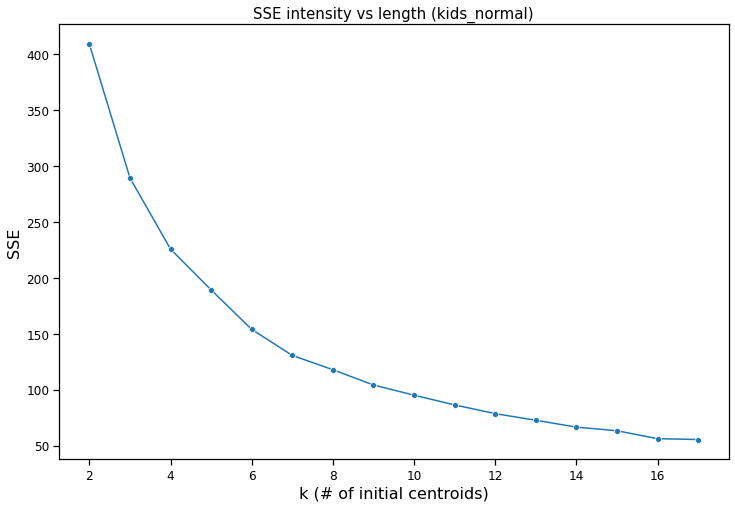

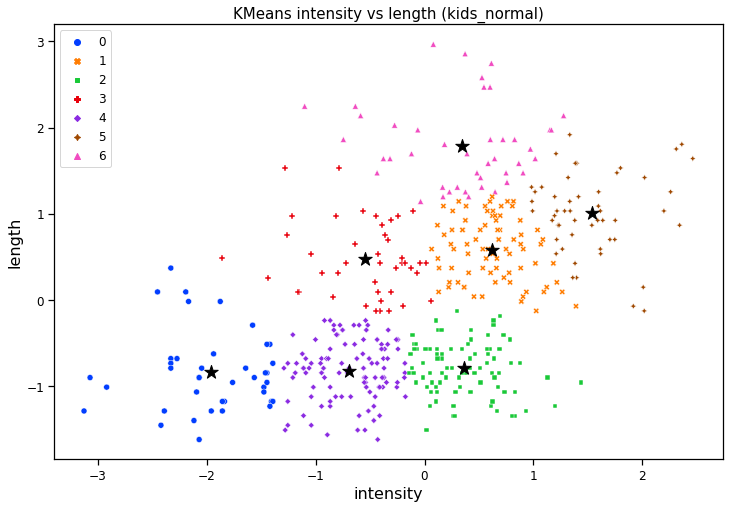

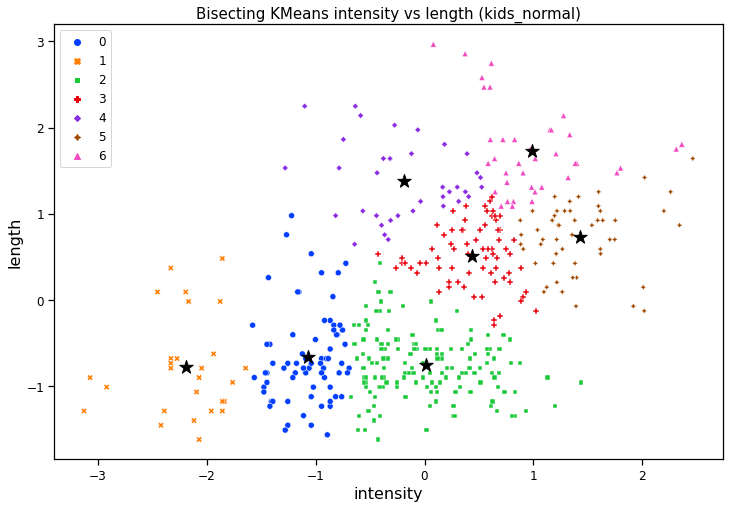

In [94]:
# cleaning df from outliers and missing values but only the couple of interest
df_cleaned = clean_outliers(kids_normal[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(kids_normal[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 7
df_name = "kids_normal"
drawSSEKMeansPlots(df_cleaned[[xvar, yvar]], indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

By partitioning by _emotional_intensity_ = "normal", the recordings of the phrase _Kids are talking by the door_ are distributed more or less equally between negative and positive intensity, with a slight preference for negative values. Furthermore, there seems to be a weak correlation between the intensity and the length of the recording, so that as one increases, the other increases as well; in fact the highest length values are recorded on average with positive intensity. As regards the number of clusters, 7 was chosen because from the SSE graph it can be seen that the curve becomes more linear with k >= 7. Finally we can see that the scatterplot is compact, with most values that can be visually split in two macro areas: the first one with low intensity, between -3 and 1, and low length, between -1.5 and 0, and the second one with positive intensity and positive length. We can also see some clustering differences between standard KMeans and Bisecting KMeans.

In [95]:
attr_part1 = "statement"
val1 = "0" # "Dogs are sitting by the door"

attr_part2 = "emotional_intensity"
val2 = "strong"

dogs_strong = partition_df(df, attr_part1, False, False)[val1]
dogs_strong = partition_df(dogs_strong, attr_part2)[val2]
dogs_strong = dogs_strong.drop(columns = to_ignore)
dogs_strong = dogs_strong.drop(columns = correlation_drop_cols)

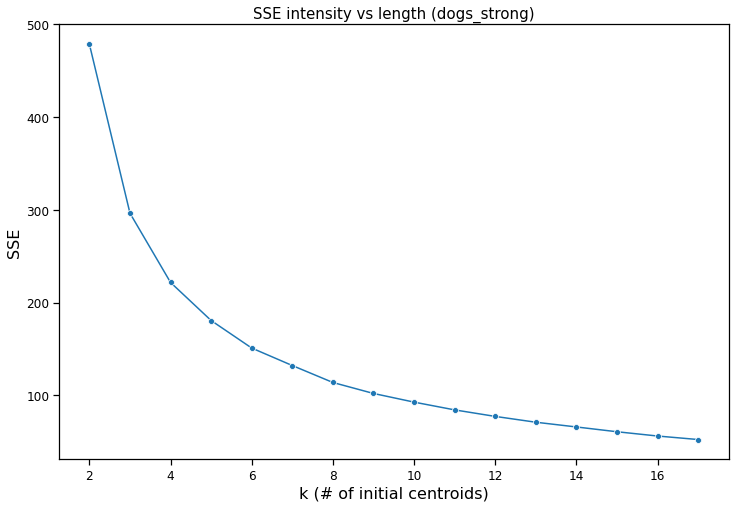

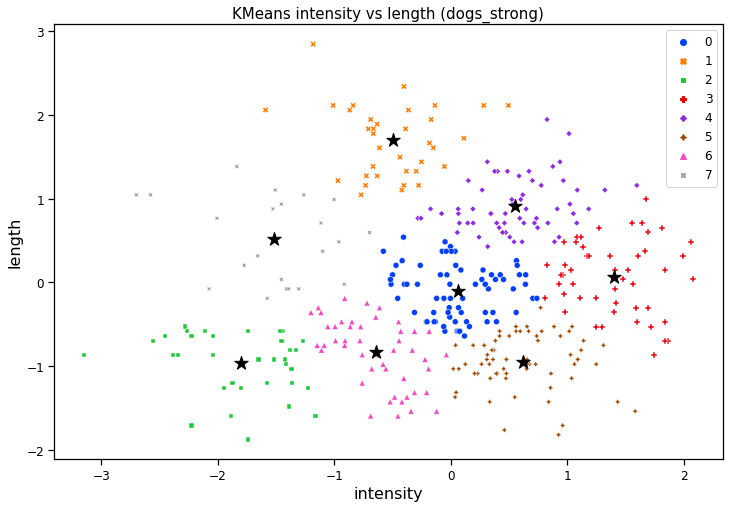

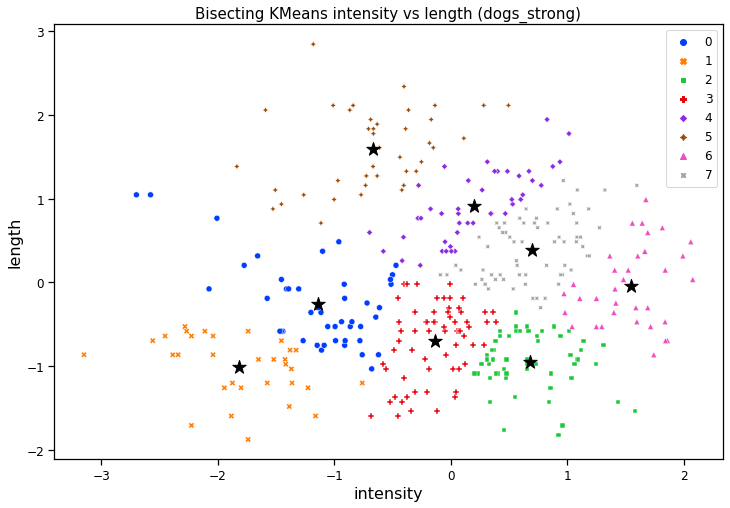

In [96]:
df_cleaned = clean_outliers(dogs_strong[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(dogs_strong[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 8
df_name = "dogs_strong"
drawSSEKMeansPlots(df_cleaned, indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

These graphs instead are built on the complementary partition to the previous one, that is with the statement _Dogs are sitting by the door_ and _emotional_intensity_ = "strong". Here too we note a normal distribution of the values on the intensity axis, with a slightly greater coverage of negative values, with a range of values approximately between -3 and 2. In this case, however, there doesn't seem to be any correlation between intensity and length, since the peaks of the latter are equally distributed between negative and positive intensities. These graphs also are compact, with most values distributed in intensity range between -2 and 2 and length range between -2 and 2. The shape of these graphs tends to be more or less globular. As before, the number of clusters was chosen through the SSE graph which shows a more linear trend with k >= 8.

In [97]:
attr_part1 = "statement"
val1 = "1" # "Kids are talking by the door"

attr_part2 = "emotional_intensity"
val2 = "strong"

kids_strong = partition_df(df, attr_part1, False, False)[val1]
kids_strong = partition_df(kids_strong, attr_part2)[val2]
kids_strong = kids_strong.drop(columns = to_ignore)
kids_strong = kids_strong.drop(columns = correlation_drop_cols)

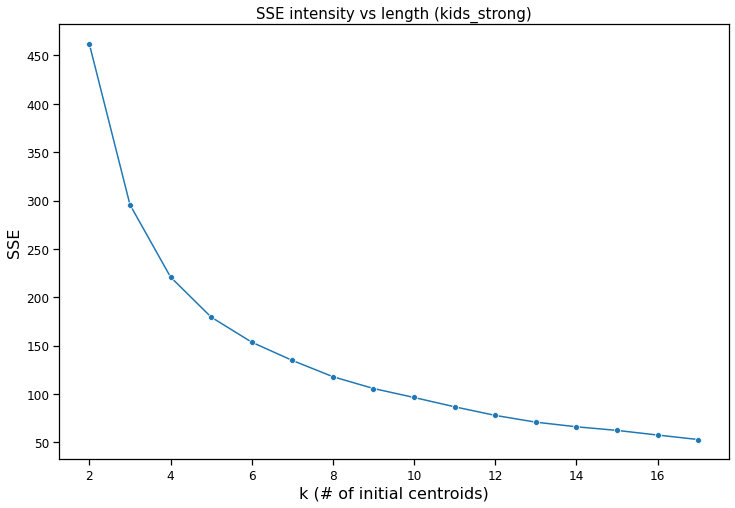

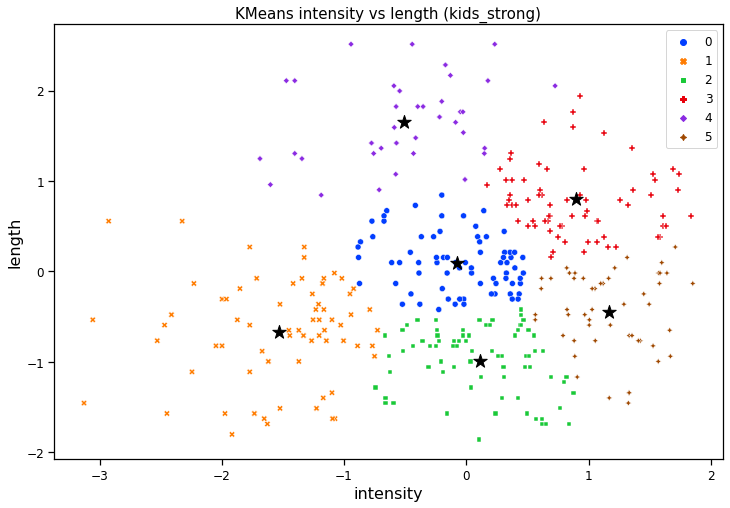

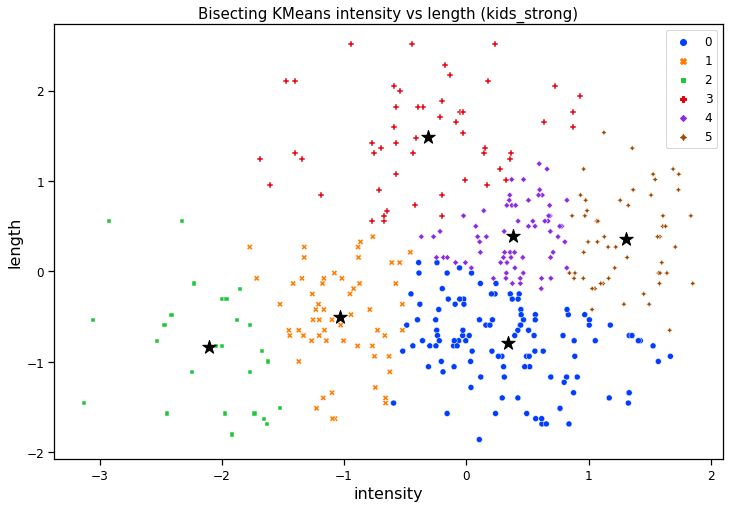

In [98]:
df_cleaned = clean_outliers(kids_strong[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(kids_strong[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 6
df_name = "kids_strong"
drawSSEKMeansPlots(df_cleaned, indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

Partitioning for _Kids are talking by the door_ and _emotional_intensity_ = "strong" we see that both the distribution of values on the X axis and the absence of correlation between the two attributes with respect to the previous partition have remained unchanged. The values of these graphs are slightly more scattered than the previous ones, with most of the values distributed on the X axis between -2.5 1.5 and on the Y axis between -1.5 and 2. There are also notable differences in clustering between standard KMeans and Bisecting KMeans, as almost all clusters are different. From the SSE graph this time we see that it is from k >= 6 that the trend becomes more linear.

In [99]:
attr_part1 = "statement"
val1 = "0" # "Dogs are sitting by the door"

attr_part2 = "emotional_intensity"
val2 = "normal"

dogs_normal = partition_df(df, attr_part1, False, False)[val1]
dogs_normal = partition_df(dogs_normal, attr_part2)[val2]
dogs_normal = dogs_normal.drop(columns = to_ignore)
dogs_normal = dogs_normal.drop(columns = correlation_drop_cols)

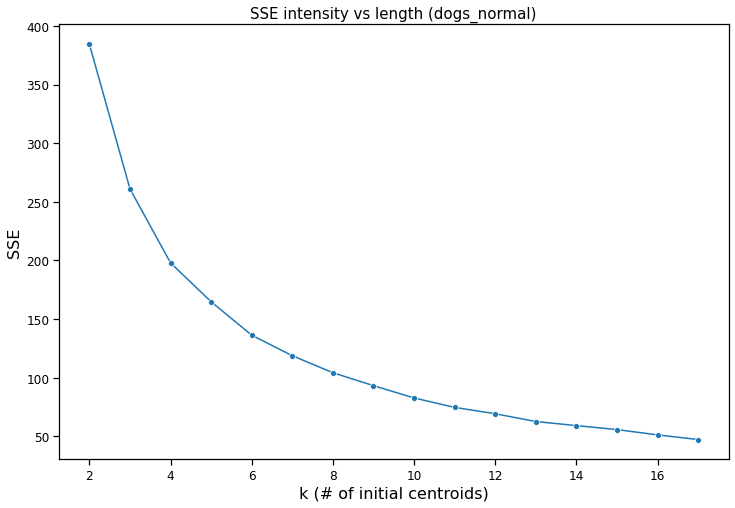

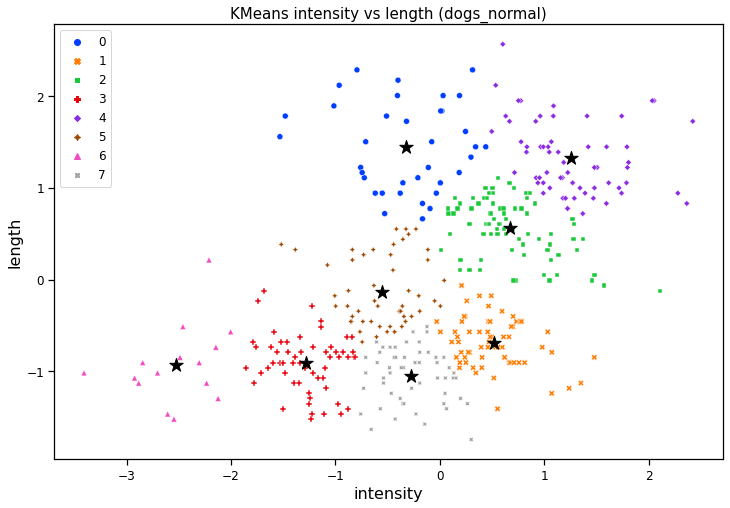

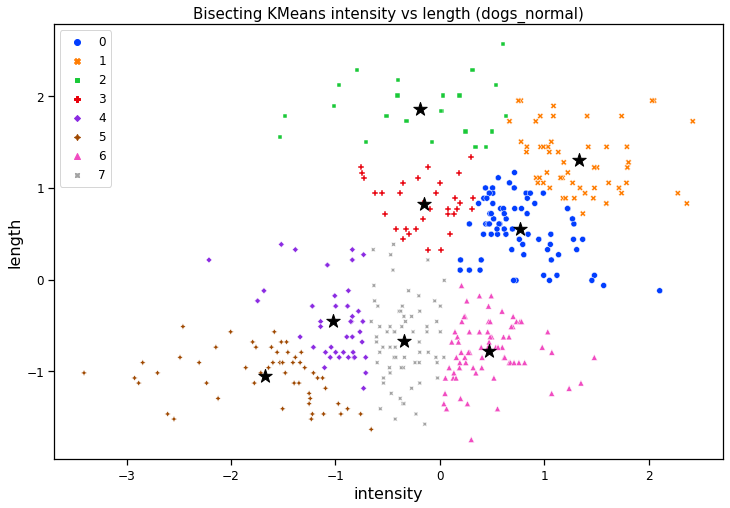

In [100]:
df_cleaned = clean_outliers(dogs_normal[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(dogs_normal[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 8
df_name = "dogs_normal"
drawSSEKMeansPlots(df_cleaned, indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

In the last partition for _Dogs are sitting by the door_ and _emotional_intensity_ = "normal" we can see that the weak correlation between the two attributes present in the first partition returns and makes us assume that this dependence is given by the partition _emotional_intensity_ = "normal" and therefore it's independent of the type of statement. For the number of clusters 8 was chosen because from the SSE graph we see that the curve begins to flatten with 6 <= k <= 10 and k = 8 is the median of this range of values. The clustering of Standard KMeans and Bisecting KMeans are quite similar to each other, there are no significant differences.

#### Partitioning and drawing plots - emotional_intensity 

In [101]:
attr_part1 = "emotional_intensity"
val1 = "normal"

emoIntensity = partition_df(df, attr_part1)[val1]
emoIntensity = emoIntensity.drop(columns = to_ignore)
emoIntensity = emoIntensity.drop(columns = correlation_drop_cols)

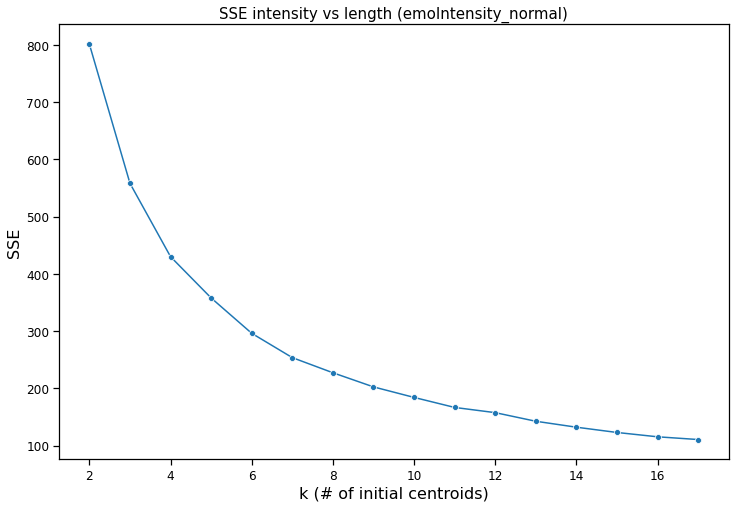

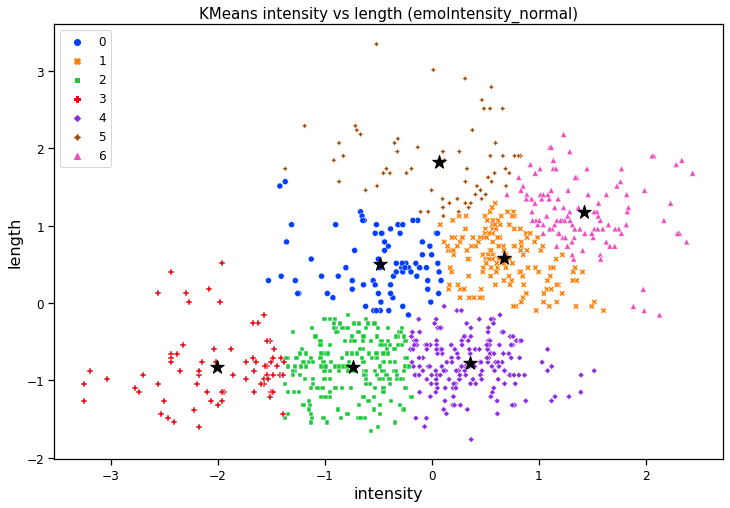

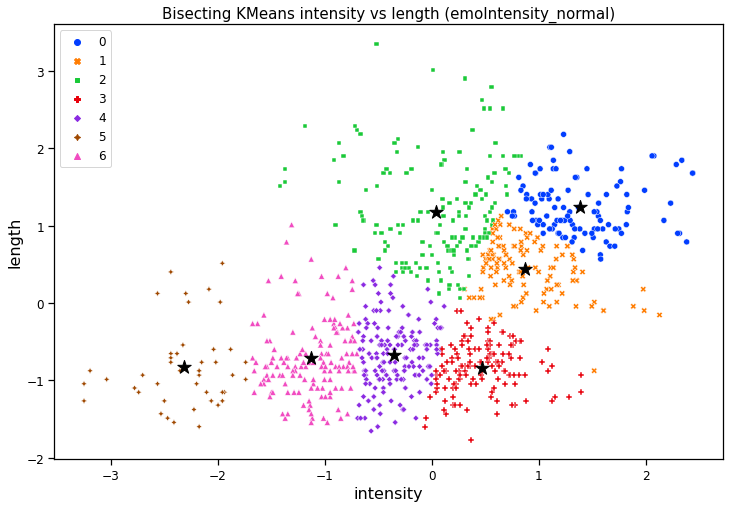

In [102]:
df_cleaned = clean_outliers(emoIntensity[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(emoIntensity[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 7
df_name = "emoIntensity_normal"
drawSSEKMeansPlots(df_cleaned, indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

7 clusters were chosen because according to the SSE graph with k >= 7 the trend of the curve becomes more linear. It can be seen that Bisecting KMeans clearly distinguishes the lower clusters in the graph, that is those with negative intensity and length values, from the higher ones, that is those with positive values of both attributes. While the KMeans standard performs a more "gradual" clustering, with two intermediate clusters that are distributed in the central area with values of both attributes around 0. The shape of the scatter plot is similar to those seen in partitions with _emotional_intensity_ = "normal ".

In [103]:
attr_part1 = "emotional_intensity"
val1 = "strong"

emoIntensity = partition_df(df, attr_part1)[val1]
emoIntensity = emoIntensity.drop(columns = to_ignore)
emoIntensity = emoIntensity.drop(columns = correlation_drop_cols)

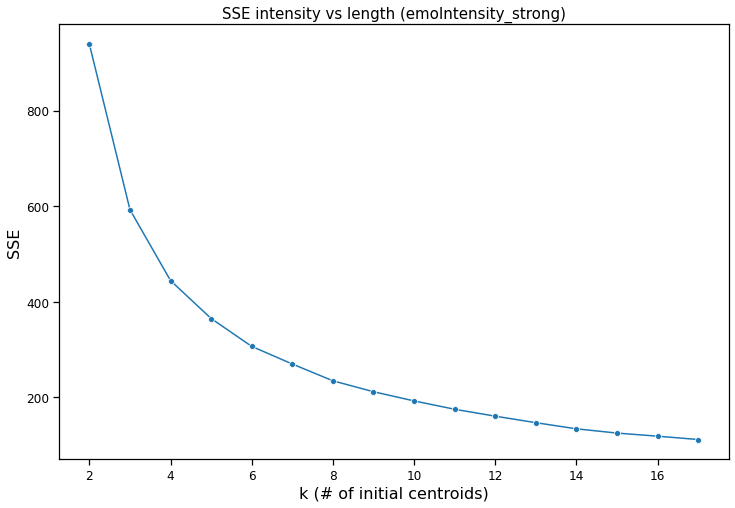

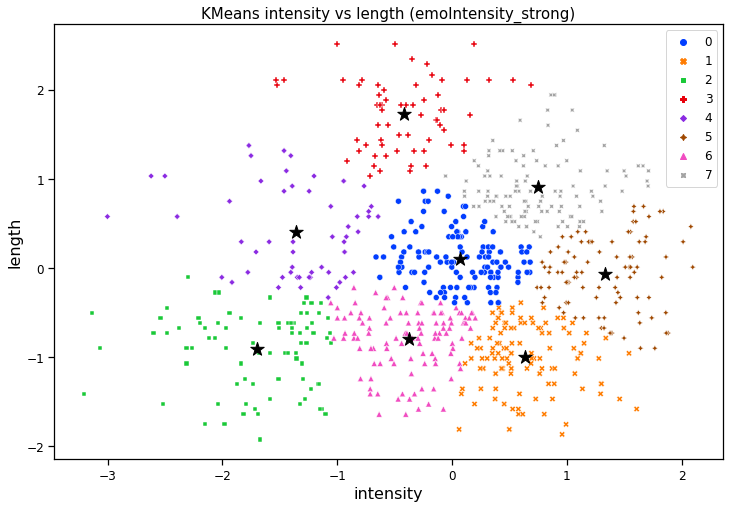

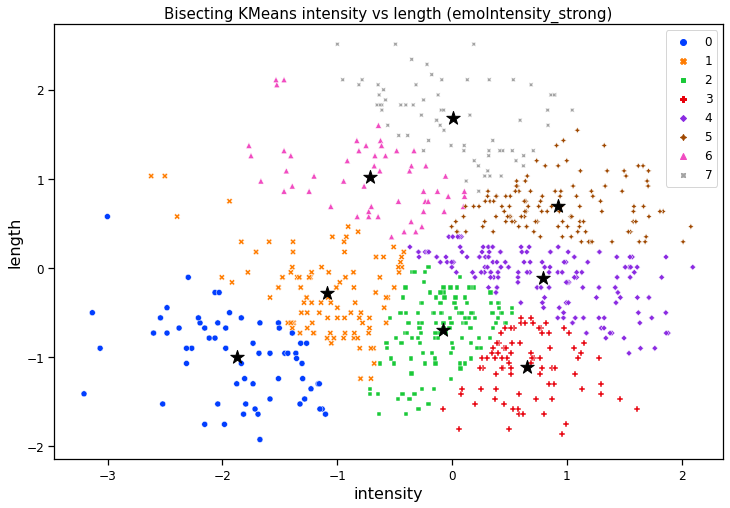

In [104]:
df_cleaned = clean_outliers(emoIntensity[["intensity", "length"]], "intensity")
df_cleaned = clean_outliers(emoIntensity[["intensity", "length"]], "length")
df_cleaned = df_cleaned.dropna()

nclust = 8
df_name = "emoIntensity_strong"
drawSSEKMeansPlots(df_cleaned, indices, xvar, yvar, df_cleaned[[xvar, yvar]], nclust, df_name)

The same goes for the previous partition, in _emotional_intensity_ = "strong" we find more or less the shape we observed in the corresponding partitions with the statements. From here we have the proof that the shape and, consequently, the presence of correlations between the attributes doesn't depend on the statement but on the value of _emotional_intensity_. Note that Bisecting KMeans tends to separate clusters around the 0 of both attributes, while the KMeans standard doesn't make this distinction and some centroids are found in line with 0 values for both attributes.

## Classification

### Choice of attributes

Each of us select a classification method and then select two variables, one to be classified by ourselves and one to be compared with the other methods, as clustering.
Classification methods:

* Naive Bayes - Claudio
* / - Andrea
* / - Steffania

Distinct variables:

* / - Claudio
* / - Andrea
* / - Steffania

Variable in common:

* /

### Naive Bayes